# Kaggle WM-811K dataset으로 wafer의 defect 불량을 CNN으로 검출해보기

In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import cross_val_score, train_test_split, KFold

import matplotlib.pyplot as plt
import cv2
import random

import warnings
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Lambda

## sklearn kfold cross validation 이용해서 검증할 모델 생성.

In [2]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = tf.math.square(y_pred)
        margin_square = tf.math.square(tf.math.maximum(margin - y_pred, 0))
        return tf.math.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)

    return contrastive_loss


def create_resnet():
    conv_base = tf.keras.applications.ResNet50(weights="imagenet",
                                            include_top=False,
                                            pooling = 'max',
                                            input_shape=(60,60,3))
    
    for layer in [l for l in conv_base.layers if 'conv5' not in l.name]:
        layer.trainable = False
    for layer in [l for l in conv_base.layers if 'conv5' in l.name or l.name == 'probs']:
        layer.trainable = True
        
    #conv_base.trainable = False
    
    model = tf.keras.Sequential()
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.2)))  
    
    return model

def euclidean_distance(vects):
    x, y = vects
    sum_square = tf.math.reduce_sum(tf.math.square(x - y), axis=1, keepdims=True)
    return tf.math.sqrt(tf.math.maximum(sum_square, 1e-7))    

checkpoint_path = "C:/Users/user/Desktop/sh/Wafer/weight/cp-{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only = True, save_freq='epoch',  monitor='val_loss', verbose=1, mode="min")

earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                              patience=7)

In [3]:
base_model = create_resnet()
input_a = Input(shape=(60,60,3), name='left_input')
vector_output_a = base_model(input_a)
input_b = Input(shape=(60,60,3), name='right_input')
vector_output_b = base_model(input_b)
output = Lambda(euclidean_distance, name='output_layer')([vector_output_a, vector_output_b])

In [4]:
max_point2 = 3

In [5]:
model_trained = Model([input_a, input_b], output)
model_trained.compile(loss=contrastive_loss_with_margin(margin=1), optimizer=Adam())

if max_point2 > 8:
    model_trained.load_weights(
        "C:/Users/user/Desktop/sh/siamese/새 폴더/weight_wafer/cp-" + str(max_point2+1) + ".ckpt"
    )
else:
    model_trained.load_weights(
        "C:/Users/user/Desktop/sh/siamese/새 폴더/weight_wafer/cp-0" + str(max_point2+1) + ".ckpt"
    )

In [6]:
path = 'C:/Users/user/Desktop/kamp/MetaLearning-pytorch/siamese/wafer/1per/test' # 폴더 경로
os.chdir(path) # 해당 폴더로 이동
error_list = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음

Center_list = []
Donut_list = []
Edge_Loc_list = []
Edge_Ring_list = []
Loc_list = []
Near_full_list = []
none_list = []
Random_list = []
Scratch_list = []

for error in error_list:
    path = 'C:/Users/user/Desktop/kamp/MetaLearning-pytorch/siamese/wafer/1per/test/' + error # 폴더 경로
    os.chdir(path) # 해당 폴더로 이동
    file_list = os.listdir(path) # 해당 폴더에 있는 파일 이름을 리스트 형태로 받음
    
    for file in file_list:
        f = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        f = f / 2
        image = cv2.resize(f, (60, 60))
        image = image[:,:, np.newaxis]
        image2 = np.repeat(image, 3, axis=2)
        
        if error == 'Center':
            Center_list.append(image2)
        elif error == 'Donut':
            Donut_list.append(image2)
        elif error == 'Edge-Loc':
            Edge_Loc_list.append(image2)
        elif error == 'Edge-Ring':
            Edge_Ring_list.append(image2)
        elif error == 'Loc':
            Loc_list.append(image2)
        elif error == 'Near-full':
            Near_full_list.append(image2)
        elif error == 'none':
            none_list.append(image2)
        elif error == 'Random':
            Random_list.append(image2)
        elif error == 'Scratch':
            Scratch_list.append(image2)                                                                               

In [7]:
len(Near_full_list)

147

In [19]:
#0은 okay / 1은 error
import random

def create_pairs(Center_list, Donut_list, Edge_Loc_list, Edge_Ring_list, Loc_list, Near_full_list, none_list, Random_list, Scratch_list, dataset_size):
    pairs = []
    answer = []
    
    for i in range(dataset_size):
        anchor_image_class = np.random.randint(9)
        answer.append(anchor_image_class)
    
        if anchor_image_class == 0:
            anchor_image_list = random.sample(Center_list, 2)
            pairs.append(anchor_image_list)
            pairs.append([anchor_image_list[0], random.sample(Donut_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Ring_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Near_full_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(none_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Random_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Scratch_list,1)[0]])
        
        elif anchor_image_class == 1:
            anchor_image_list = random.sample(Donut_list, 2)
            pairs.append([anchor_image_list[0], random.sample(Center_list,1)[0]])
            pairs.append(anchor_image_list)
            pairs.append([anchor_image_list[0], random.sample(Edge_Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Ring_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Near_full_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(none_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Random_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Scratch_list,1)[0]])            
            
        elif anchor_image_class == 2:
            anchor_image_list = random.sample(Edge_Loc_list, 2)
            
            pairs.append([anchor_image_list[0], random.sample(Center_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Donut_list,1)[0]])
            pairs.append(anchor_image_list)
            pairs.append([anchor_image_list[0], random.sample(Edge_Ring_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Near_full_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(none_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Random_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Scratch_list,1)[0]])  

        elif anchor_image_class == 3:
            anchor_image_list = random.sample(Edge_Ring_list, 2)
            
            pairs.append([anchor_image_list[0], random.sample(Center_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Donut_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Loc_list,1)[0]])
            pairs.append(anchor_image_list)
            pairs.append([anchor_image_list[0], random.sample(Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Near_full_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(none_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Random_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Scratch_list,1)[0]])  
            
        elif anchor_image_class == 4:
            anchor_image_list = random.sample(Loc_list, 2)
            
            pairs.append([anchor_image_list[0], random.sample(Center_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Donut_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Ring_list,1)[0]])
            pairs.append(anchor_image_list)
            pairs.append([anchor_image_list[0], random.sample(Near_full_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(none_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Random_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Scratch_list,1)[0]])
            
        elif anchor_image_class == 5:
            anchor_image_list = random.sample(Near_full_list, 2)
            
            pairs.append([anchor_image_list[0], random.sample(Center_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Donut_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Ring_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Loc_list,1)[0]])
            pairs.append(anchor_image_list)
            pairs.append([anchor_image_list[0], random.sample(none_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Random_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Scratch_list,1)[0]])                  
                                                
        elif anchor_image_class == 6:
            anchor_image_list = random.sample(none_list, 2)
            
            pairs.append([anchor_image_list[0], random.sample(Center_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Donut_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Ring_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Near_full_list,1)[0]])
            pairs.append(anchor_image_list)
            pairs.append([anchor_image_list[0], random.sample(Random_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Scratch_list,1)[0]])                  

        elif anchor_image_class == 7:
            anchor_image_list = random.sample(Random_list, 2)
            
            pairs.append([anchor_image_list[0], random.sample(Center_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Donut_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Ring_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Near_full_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(none_list,1)[0]])
            pairs.append(anchor_image_list)
            pairs.append([anchor_image_list[0], random.sample(Scratch_list,1)[0]])                  

        elif anchor_image_class == 8:
            anchor_image_list = random.sample(Scratch_list, 2)
            
            pairs.append([anchor_image_list[0], random.sample(Center_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Donut_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Edge_Ring_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Loc_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Near_full_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(none_list,1)[0]])
            pairs.append([anchor_image_list[0], random.sample(Random_list,1)[0]])
            pairs.append(anchor_image_list)
              
            
                                                                       
    
    return np.array(pairs), answer

test_X_pair, answer = create_pairs(Center_list, Donut_list, Edge_Loc_list, Edge_Ring_list, Loc_list, Near_full_list, none_list, Random_list, Scratch_list, 3000)

In [20]:
test_X_pair.shape

(27000, 2, 60, 60, 3)

In [21]:
y_pred = model_trained.predict([test_X_pair[:, 0, :,:,:] , test_X_pair[:, 1, :,:,:]])
y_pred = y_pred.reshape(-1,9)

result = []

prediction = []

for i in range(y_pred.shape[0]):
    if (np.argmin(y_pred[i]) == answer[i]):
        result.append(1.0)
    else:
        result.append(0.0)
        
    prediction.append(np.argmin(y_pred[i]))

score = np.mean(result)
score

0.37833333333333335

In [22]:
answer[2]

0

In [23]:
y_pred[2]

array([0.23380394, 0.11887501, 0.5222121 , 0.9430542 , 0.34054154,
       0.6154027 , 0.5250228 , 0.4804982 , 0.4777499 ], dtype=float32)

In [24]:
y_pred[2].min()

0.11887501

In [25]:
np.argmin(y_pred[2])

1

In [26]:
result[2]

0.0

In [27]:
import itertools

def plot_confusion_matrix(con_mat, labels, title='Confusion Matrix', cmap=plt.cm.get_cmap('Blues'), normalize=False):
    plt.figure(figsize=(12,12))
    plt.imshow(con_mat, interpolation='nearest', cmap=cmap)
    
    plt.title(title)
    plt.colorbar()
    marks = np.arange(len(labels))
    nlabels = []
    for k in range(len(con_mat)):
        n = sum(con_mat[k])
        nlabel = '{0}(n={1})'.format(labels[k],n)
        nlabels.append(nlabel)
    plt.xticks(marks, labels, rotation=45)
    plt.yticks(marks, nlabels)

    thresh = con_mat.max() / 2.
    if normalize:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, '{0}%'.format(np.round(con_mat[i, j] * 100 / n , 2)), horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    else:
        for i, j in itertools.product(range(con_mat.shape[0]), range(con_mat.shape[1])):
            plt.text(j, i, con_mat[i, j], horizontalalignment="center", color="white" if con_mat[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [28]:
from sklearn.metrics import confusion_matrix
#rounded_labels=np.argmax(test_image_label, axis=1)
#rounded_labels

#y_pred = model.predict_classes(np.array(val_image_list))
cf = confusion_matrix(answer, prediction)
cf

array([[105,  79,  15,   1,  43,   0,  22,  14,  41],
       [102, 139,  17,   1,  45,   3,   4,  11,  20],
       [ 16,   6,  88,  27,  41,  19,  70,  30,  58],
       [  2,   0,  32, 233,   4,  44,   5,   3,   5],
       [ 52,  27,  41,   4,  66,   0,  65,  18,  58],
       [  0,   1,  20,  44,   3, 170,   1,  80,   1],
       [ 21,   3,  37,   1,  58,   1, 118,   1,  79],
       [ 24,  14,  39,   9,  21,  73,   8, 146,  22],
       [ 39,  18,  48,  10,  67,   0,  70,   7,  70]], dtype=int64)

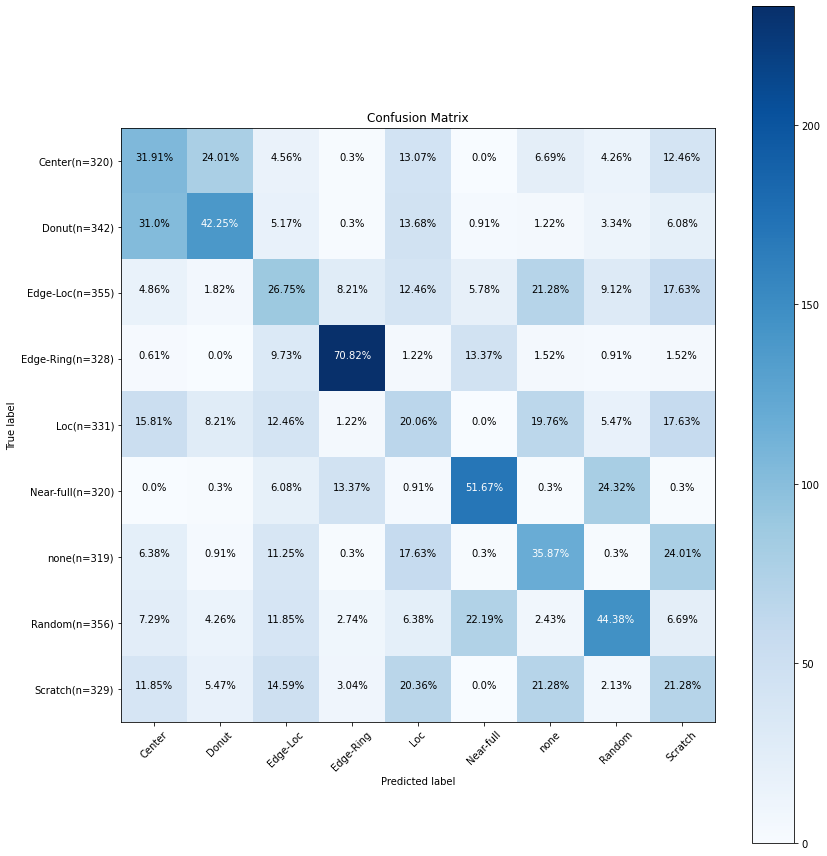

In [29]:
label = error_list
plot_confusion_matrix(cf, labels=label, normalize=True)